# Learning Rate schedules in Practice

This is a notebook for the medium article [Learning Rate schedule in Practice](https://medium.com/@bindiatwork/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c)

Please check out article for instructions

**License**: [BSD 2-Clause](https://opensource.org/licenses/BSD-2-Clause)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Fashion MMIST dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [5]:
X_train_full.dtype

dtype('uint8')

In [6]:
# For faster training, let's use a subset 10,000
X_train, y_train = X_train_full[:10000] / 255.0, y_train_full[:10000]

## Building a NN model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_model(): 
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    return model

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Helper functions for plotting

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [10]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

## 1. Constant Learning Rate

In [11]:
# Create a new model
model = create_model()

In [12]:
# Learning rate defaults to 0.01 according to https://keras.io/api/optimizers/sgd/
# To use a custom Learning Rate
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=sgd, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history_constant = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 1s 178us/sample - loss: 1.4910 - accuracy: 0.5939 - val_loss: 1.0801 - val_accuracy: 0.6875
Epoch 2/100
8000/8000 [==============================] - 1s 67us/sample - loss: 0.9260 - accuracy: 0.7188 - val_loss: 0.8577 - val_accuracy: 0.7160
Epoch 3/100
8000/8000 [==============================] - 1s 68us/sample - loss: 0.7750 - accuracy: 0.7496 - val_loss: 0.7544 - val_accuracy: 0.7560
Epoch 4/100
8000/8000 [==============================] - 1s 67us/sample - loss: 0.6967 - accuracy: 0.7731 - val_loss: 0.6986 - val_accuracy: 0.7630
Epoch 5/100
8000/8000 [==============================] - 1s 69us/sample - loss: 0.6464 - accuracy: 0.7908 - val_loss: 0.6592 - val_accuracy: 0.7770
Epoch 6/100
8000/8000 [==============================] - 1s 69us/sample - loss: 0.6122 - accuracy: 0.7971 - val_loss: 0.6402 - val_accuracy: 0.7785
Epoch 7/100
8000/8000 [==============================] - 1s 70u

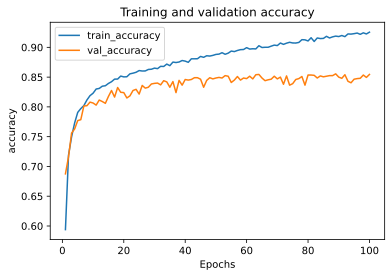

In [13]:
plot_metric(history_constant, 'accuracy')

## 2. Time-Based Decay

In [15]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

history_time_based_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/100
8000/8000 [==============================] - 1s 146us/sample - loss: 1.6332 - accuracy: 0.5425 - val_loss: 1.1615 - val_accuracy: 0.6595

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009998999876494932.
Epoch 2/100
8000/8000 [==============================] - 1s 70us/sample - loss: 0.9720 - accuracy: 0.7063 - val_loss: 0.8714 - val_accuracy: 0.7135

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009997000136010244.
Epoch 3/100
8000/8000 [==============================] - 1s 68us/sample - loss: 0.7963 - accuracy: 0.7459 - val_loss: 0.7679 - val_accuracy: 0.7485

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009994001785933966.
Epoch 4/100
8000/8000 [==============================] - 1s 69us/sample - loss: 0.7131 - accuracy: 0.7686 - val_loss: 0.7078 - val_accuracy: 0.7625

Epoch 00005: LearningR

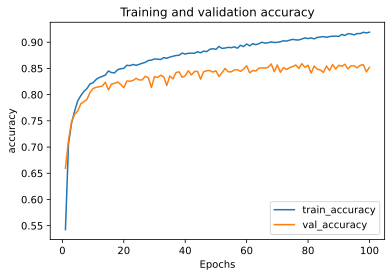

In [17]:
plot_metric(history_time_based_decay, 'accuracy')

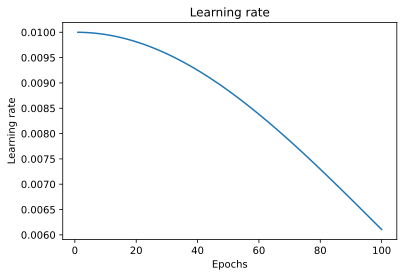

In [18]:
plot_lr(history_time_based_decay)

## 3. Step decay

In [24]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [25]:
# Define the learning rate schedule function
initial_learning_rate = 0.01

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Fit the model to the training data
history_step_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
8000/8000 [==============================] - 1s 145us/sample - loss: 1.5509 - accuracy: 0.5437 - val_loss: 1.1118 - val_accuracy: 0.6640

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
8000/8000 [==============================] - 1s 71us/sample - loss: 0.9472 - accuracy: 0.6940 - val_loss: 0.8605 - val_accuracy: 0.7050

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
8000/8000 [==============================] - 1s 66us/sample - loss: 0.7901 - accuracy: 0.7385 - val_loss: 0.7603 - val_accuracy: 0.7420

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
Epoch 4/100
8000/8000 [==============================] - 1s 67us/sample - loss: 0.7092 - accuracy: 0.7648 - val_loss: 0.7079 - val_accuracy: 0.7495

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
Epoch 5/100
8000/80

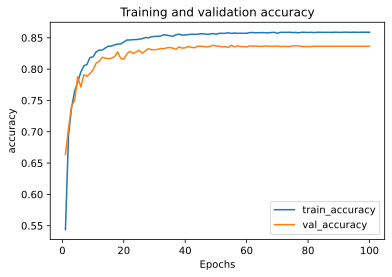

In [26]:
plot_metric(history_step_decay, 'accuracy')

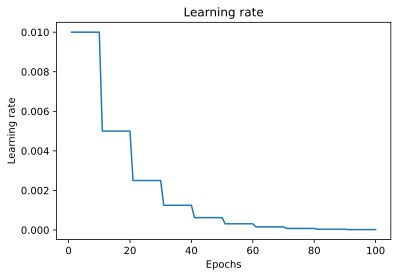

In [27]:
plot_lr(history_step_decay)

## 4. Exponential Decay

In [30]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [31]:
initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

# Fit the model to the training data
history_exp_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
8000/8000 [==============================] - 1s 137us/sample - loss: 1.5663 - accuracy: 0.5537 - val_loss: 1.1171 - val_accuracy: 0.6670

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009048374180359595.
Epoch 2/100
8000/8000 [==============================] - 1s 66us/sample - loss: 0.9513 - accuracy: 0.7153 - val_loss: 0.8652 - val_accuracy: 0.7215

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008187307530779819.
Epoch 3/100
8000/8000 [==============================] - 1s 66us/sample - loss: 0.7915 - accuracy: 0.7530 - val_loss: 0.7659 - val_accuracy: 0.7545

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007408182206817179.
Epoch 4/100
8000/8000 [==============================] - 1s 68us/sample - loss: 0.7177 - accuracy: 0.7678 - val_loss: 0.7187 - val_accuracy: 0.7595

Epoch 00005: LearningRateScheduler red

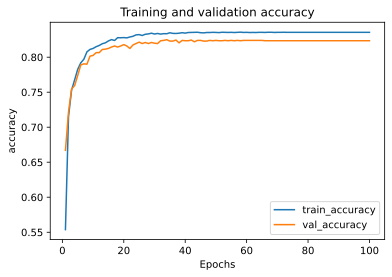

In [32]:
plot_metric(history_exp_decay, 'accuracy')

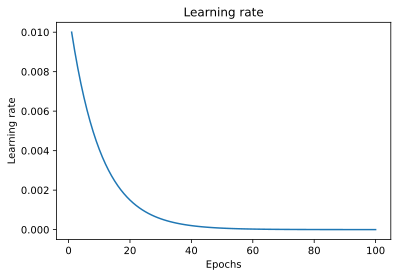

In [33]:
plot_lr(history_exp_decay)

## Compare model accuracy

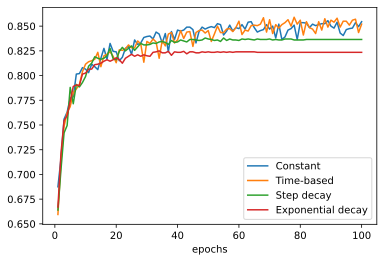

In [34]:
epochs = range(1, 101)
plt.plot(epochs,history_constant.history['val_accuracy'],label='Constant')
plt.plot(epochs,history_time_based_decay.history['val_accuracy'],label='Time-based')
plt.plot(epochs,history_step_decay.history['val_accuracy'],label='Step decay')
plt.plot(epochs,history_exp_decay.history['val_accuracy'],label='Exponential decay')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.show()